# Lab 5 - EE350
# Filtres RIF

À rendre le 8 décembre 2021

In [1]:
from __future__ import division
from scipy import signal, fft
import numpy as np
np.seterr(divide = 'ignore') 
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
from IPython.display import Image
import pyaudio  
import wave  
import time

## Exercice 1: Synthèse d'un filtre dérivateur

L'objectif de cet exercice est de créer un filtre estimant la dérivée seconde d'un signal. Considérez pour l'exercice $f_e=10 Hz$.

### 1.

On peut d'abord essayer de définir un tel filtre grâce à l'estimation aux différences finies de la dérivée seconde:
\begin{equation}
    h[n] = f_e^2\left(\delta[n] - 2\delta[n-1] + \delta[n-2]\right),
\end{equation}
où $f_e$ est la fréquence d'échantillonage.

* Déterminez analytiquement la réponse en fréquence $H(\omega)$ du filtre défini par $h$.
* Justifiez si ce filtre a une phase linéaire ou non.
* Affichez $H(\omega)$ sur un diagramme de Bode.

AttributeError: 'AxesSubplot' object has no attribute 'semilog'

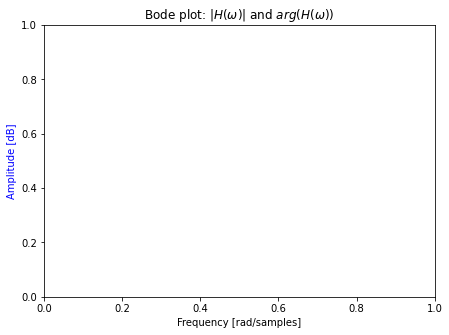

In [102]:
def dB(x):
    return 20 * np.log10(abs(x))

def normVect(v):
    v /= np.linalg.norm(v)

b= np.array([100, -200, 100])
a= np.array([1, 0, 0])

N_points= 1024 
w, h= signal.freqz(b,a,N_points)
angles_rad = np.unwrap(np.angle(h))

fig, ax1 = plt.subplots(1,1,figsize=(7,5))

ax1.set_xlabel('Frequency [rad/samples]')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_title('Bode plot: $|H(\omega)|$ and $arg(H(\omega))$')
ax1.loglog(w, dB(h), color='b')

ax2 = ax1.twinx()
ax2.semilog(w, angles_rad, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.plot(w, angles_rad, color='g')
ax2.grid()

plt.show()

**Réponse :**

Given that $f_e= 10$Hz, and the following equation from the problem statement,

$$\begin{align}
h[n] &= f_e^2(\delta[n] -2\delta[n-1] +\delta[n-2]) \\
\end{align}
$$

Calculating the Fourier Transform of $h[n]$ using the Fourier Transform tables we obtain the following:

$$\begin{align}
H(\omega) &= 100(1-2e^{-j\omega}+e^{-j2\omega})
\end{align}
$$

This filter (of size $M=3$) has a linear phase, as it satisfies $h[n]= h[2-n]$  $\forall n\in [0,2]$. We can also deduce that the filter has a linear phase from observing the bode plot.

See above for the Bode plot.

### 2. 
On considère les signaux $x_1(t) = \sin(1.5 * 2 \pi t)$ et $x_2(t) = \cos(4 * 2 \pi t)$.
* Calculez analytiquement leurs dérivées $y_1(t)$ et $y_2(t)$.

* Discrétisez les signaux $x_1$ et $x_2$ et prenez leurs $64$ premiers échantillons. Calculez ensuite le résultat de l'application du filtre $h$ aux deux signaux échantillonés pour trouver des estimations de leurs dérivées secondes (*vous pouvez vous aider de la fonction np.convolve, attention aux conditions de bords*). Affichez les estimations des dérivées secondes de même que les versions échantillonées des signaux $y_1(t)$ et $y_2(t)$. 

* Est-ce que le filtre procure une bonne estimation (en amplitude et en phase) des dérivées de $x_1$ et $x_2$ ? Justifiez.

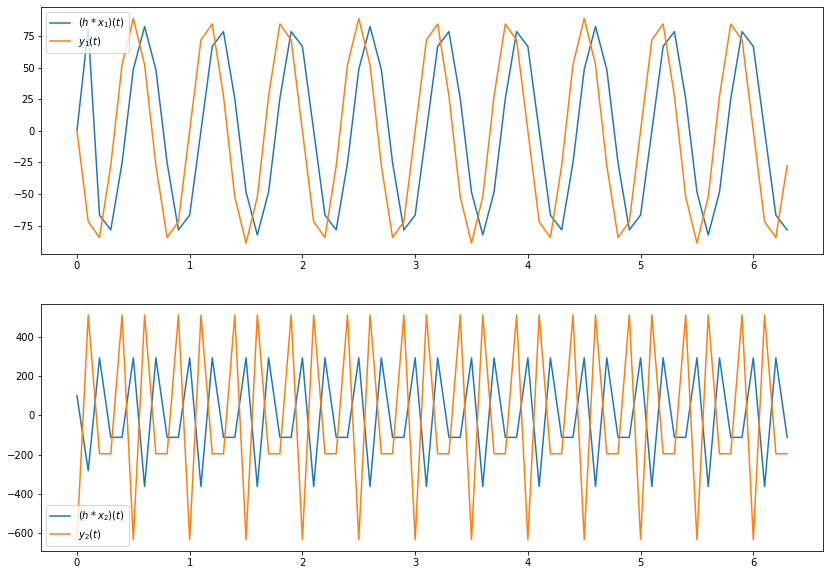

In [3]:
f_e= 10.0 #Hz
num_samples= 64

t= np.arange(0, num_samples/f_e, 1/f_e)
x1= np.sin(1.5 * (2*np.pi*t))
x2= np.cos(4 * (2*np.pi*t))

#second derivatives 
y1= -9*(np.pi**2) * np.sin(1.5 * (2*np.pi*t))
y2= -64*(np.pi**2) * np.cos(4 * (2*np.pi*t))

# frequency response of digital filter
h=  np.array([100, -200, 100])
# a= np.array([1, 0, 0])
# (t_out, h) = signal.dimpulse((b, a,1))

out1 = np.convolve(x1, h, 'full')[:-2]
out2 = np.convolve(x2, h, 'full')[:-2]

fig, axs = plt.subplots(2,1, figsize=(14,10))

pts= len(t) #number of points to observe in graph
axs[0].plot(t,out1,label="$(h*x_1)(t)$")
axs[0].plot(t,y1,label="$y_1(t)$")
axs[0].legend()

axs[1].plot(t,out2,label="$(h*x_2)(t)$")
axs[1].plot(t,y2,label="$y_2(t)$")
axs[1].legend()
plt.show()

**Réponse :** 

Since $(h*x_1)(t)$ is out of phase with $y_1(t)$ and $(h*x_2)(t)$ is out of phase with $y_2(t)$, the filter $h[n]$ provides a good estimation of $y_1(t)=x_1''(t)$ and $y_2(t)= x_2''(t)$, in terms of amplitude, but not necessarily in terms of phase. ***Don't normalize***

### 3. 

La dérivée seconde continue est une opération linéaire et invariante dans le temps, on peut donc calculer sa fonction de transfer $D(\omega)$.
* Donnez $D(\omega)$.
* Calculez analytiquement, en utilisant la synthèse par fenêtrage, la réponse impulsionelle théorique (i.e., de longueur infinie) $h_d[n]$.

**Réponse :** 

From the FT tables, the frequency response of a second derivative LTI system is $D(\omega)=(j\omega)^2=-\omega^2$

$\begin{align}
h_d[n] &= \frac{1}{2\pi} \int_{-f_e/2}^{f_e/2}D(\omega)e^{j\omega n}d\omega \\
\end{align}$

Assuming $n\neq0$, we obtain the following expression for $h_d[n]$,

$\begin{align}
h_d[n] &= -\frac{1}{2\pi} \left[ \frac{\omega^2}{jn}e^{j\omega n} - \frac{2}{jn}\left( \frac{\omega}{jn}e^{j\omega n} +\frac{1}{n^2}e^{j\omega n} \right) \right]^{\pi}_{-\pi} \\
       &= -\frac{1}{2\pi} \left[ \frac{\omega^2}{jn}e^{j\omega n} + \frac{2\omega}{n^2}e^{j\omega n} -\frac{2} \\{jn^3}e^{j\omega n} \right]^{\pi}_{-\pi} \\
       &= -\frac{1}{2\pi} \left[ \frac{2\pi}{n^2}e^{j\pi n} - \left( -\frac{2\pi}{n^2}e^{-j\pi n} \right) \right] \\
       &= -\frac{2}{n^2}\cos(\pi n) \\
\end{align}$

Assuming $n=0$, we obtain the following expression for $h_d[n]$,

$\begin{align}
h_d[n] &= -\frac{1}{2\pi} \int_{-\pi}^{\pi}(\omega^2)e^{j\omega (0)}d\omega \\
       &= -\frac{1}{6\pi} \left[ \omega^3 \right]^{\pi}_{-\pi} \\
       &= -\frac{\pi^2}{3} \\
\end{align}$

Therefore we obtain the following piecewise function for $h_d[n]$
$$
h_d[n]=  \begin{cases} 
      -\frac{2}{n^2}\cos(\pi n) & n\neq 0 \\
      -\frac{\pi^2}{3} & n = 0 
   \end{cases}
$$


### 4.

Afin d'être implémenté, le signal $h_d[n]$ doit être fenêtré.
* Considérez d'abord une fenêtre rectangulaire de taille $5$, appliquez-la à $h_d[n]$ (faites attention au décalage et à la fréquence d'échantillonage). Appliquez le filtre résultant aux signaux $x_1$, $x_2$ et affichez les resultats de même que  les versions échantillonées de $y_1$ et $y_2$
* Répétez la même opération avec une fenêtre de taille $11$
* Répétez la même opération avec des fenêtres de Hanning de taille $5$ et $11$.
* Est-ce que les résultats sont de bonnes estimations (en amplitude et en phase) des dérivées secondes de $x_1$ et $x_2$ (i.e., les versions échantillonées de $y_1$ et $y_2$)? Que se passe-t-il au début du signal ? Justifiez.

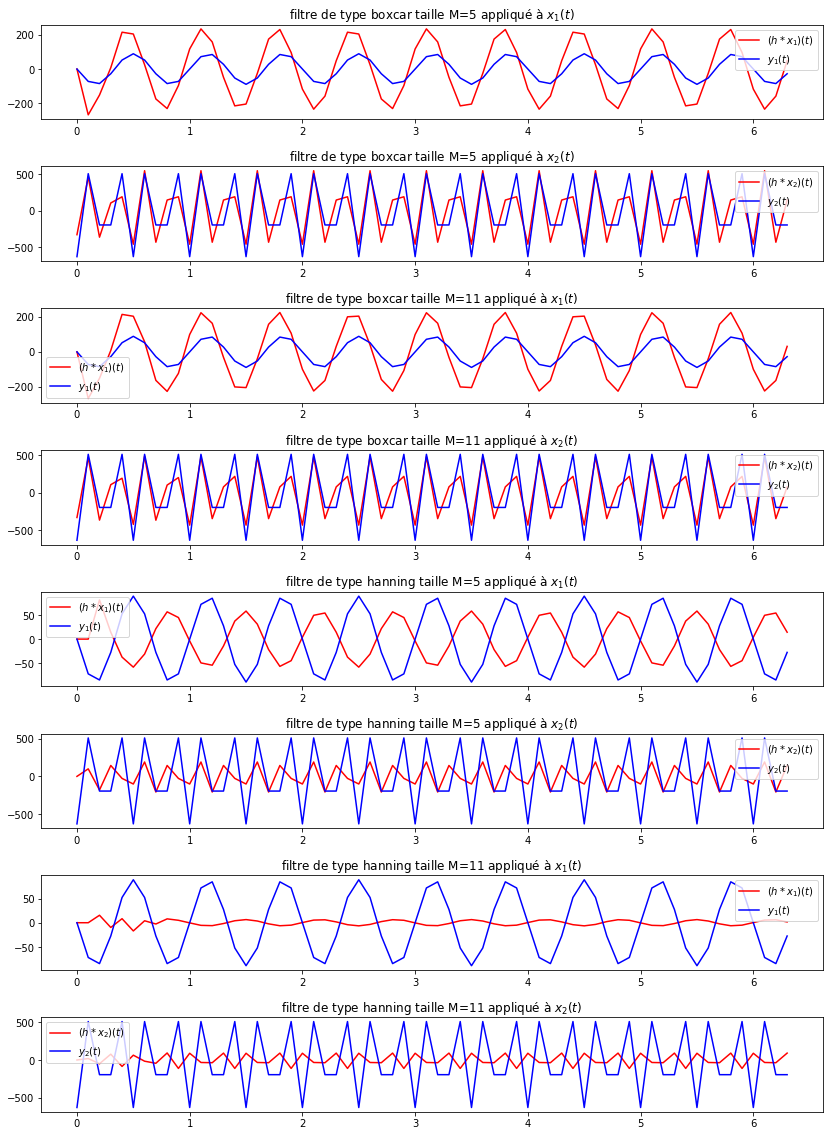

In [95]:
def resp_plt(a_coeffs, b_coeffs, window_type, win_size, axs):
    num_samples= 64
    f_e= 10 #Hz

    t= np.arange(0, num_samples/f_e, 1/f_e)
    
    x1= np.sin(1.5 * (2*np.pi*t))
    x2= np.cos(4 * (2*np.pi*t))

    #derivatives 
    y1= -9*(np.pi**2) * np.sin(1.5 * (2*np.pi*t))
    y2= -64*(np.pi**2) * np.cos(4 * (2*np.pi*t))

    # frequency response of digital filter

    (t_out, h_d) = signal.dimpulse((b_coeffs, a_coeffs, 1),n=num_samples)
    h_d = np.squeeze(h_d)

    #apply the window to h_d[n]
    w= signal.get_window(window_type, win_size, fftbins=False)
    h_d_windowed = h_d[:win_size]*w

    out1 = np.convolve(x1, h_d_windowed)
    out2 = np.convolve(x2, h_d_windowed)

    axs[0].plot(t, out1[:len(t)], color='r', label="$(h*x_1)(t)$")
    axs[0].plot(t, y1, color='b', label="$y_1(t)$")
    axs[0].set_title("filtre de type {} taille M={} appliqué à $x_1(t)$".format(window_type, win_size))
    axs[0].legend()
    #axs[0].plot(t, y1, color='g')

    axs[1].plot(t, out2[:len(t)], color='r', label="$(h*x_2)(t)$")
    axs[1].plot(t, y2, color='b', label="$y_2(t)$")
    axs[1].set_title("filtre de type {} taille M={} appliqué à $x_2(t)$".format(window_type, win_size))
    axs[1].legend()
    #axs[1].plot(t, y2, color='g')

    
# frequency response of digital filter
a= np.zeros(num_samples)
a[0]= 1.0
f_e=10 #Hz
b= np.zeros(num_samples)
for n in range(num_samples): #avoid div by zero
    if(n == 0):
        b[n]= -((np.pi**2) /3) * (f_e**2)
    else:
        b[n]= (-2/n) * np.cos(np.pi * n) * (f_e**2)

    
fig, axs = plt.subplots(8, 1, figsize=(14,20))
fig.subplots_adjust(hspace = 0.5)

resp_plt(a, b, 'boxcar', 5, [axs[0], axs[1]])
resp_plt(a, b, 'boxcar', 11, [axs[2], axs[3]])

resp_plt(a, b, 'hanning', 5, [axs[4], axs[5]])
resp_plt(a, b, 'hanning', 11, [axs[6], axs[7]])

plt.show()    

**Réponse :** 

Le filtre hanning approxime $y_2(t)$ largement mieux que le filtre rectangulaire. Augmenter l'ordre du filtre $M$ améliore son approximation de $y_2(t)$, $(h_d * x_2)(t)$, en terme d'amplitude. Par contre, augmenter l'ordre du filtre de $M=5$ à $M=11$ n'améliore pas son approximation de $y_1(t)$, $(h_d * x_1)(t)$, en terme d'amplitude. Augmenter l'ordre du filtre améliore l'approximation de $y_2(t)$ (mais pas $y_1(t)$) en terme de phase.

Augmenter l'ordre du filtre rectangulaire de $M=5$ à $M=11$ n'améliore pas son approximation de $y_1(t)$, $(h_d * x_1)(t)$, ni son approximation de $y_2(t)$, $(h_d * x_2)(t)$, en terme d'amplitude. Le décalage de phase est plus grand pour le filtre rétangulaire que pour le filtre de hamming. Changer l'ordre du filtre réctangulaire ne diminue pas l'éffet du décalage de phase.

### 5.

Affichez sur un même diagramme de Bode les réponses en amplitude et en phase de la réponse impulsionelle $h[n]$ et des différents versions fenêtrée de la réponse impulsionelle $h_d[n]$. Affichez aussi l'amplitude d'une version idéalisée du filtre (i.e., l'amplitude de $D(\omega)$).

* Décrivez les principales différences entre les filtres.
* D'après vous, quel filtre donne la meilleure estimation de la dérivée seconde d'un signal ? Cette réponse dépend-elle du contenu fréquenciel du signal ?

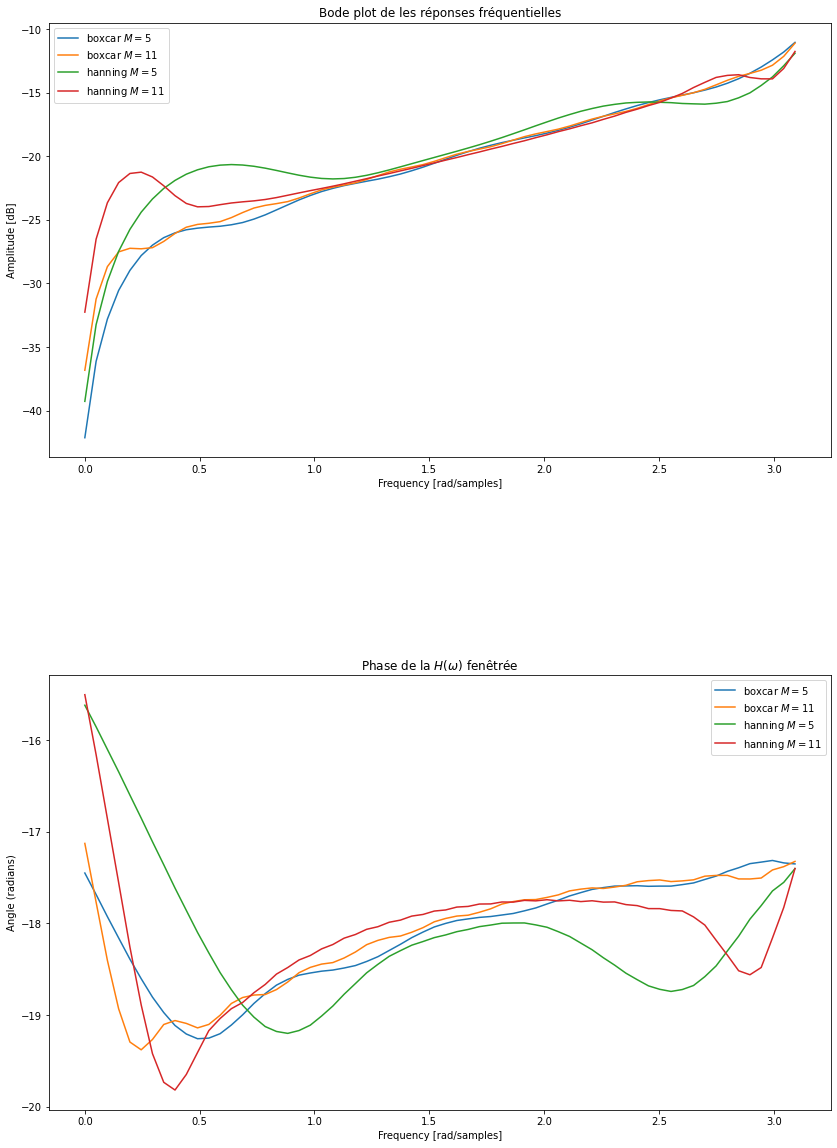

In [5]:
def resp_bode_plt(a_coeffs, b_coeffs, window_type, win_size, axs):
    num_samples= 64
    f_e= 10 #Hz
    
    #filter freq. and impulse responses
    w, Hd = signal.freqz(b_coeffs, a_coeffs, num_samples)
    (t_out, hd) = signal.dimpulse((b_coeffs, a_coeffs, 1), n=num_samples)
    hd = np.squeeze(hd)
    
    #freq. response of windowed h_d[n]
    tmp = signal.get_window(window_type, win_size, fftbins=False)
    window= np.zeros(num_samples)
    window[:win_size]= tmp

    W = np.fft.fft(window)
    Hd_w= np.convolve(W, Hd, 'full')[:num_samples]

    Hd_phase = np.unwrap(np.angle(Hd))
    Hd_w_phase= np.unwrap(np.angle(Hd_w))
    
    #Normalize vectors to compare
    normVect(Hd_w)
    normVect(Hd_w_phase)
    
    axs[0].set_xlabel('Frequency [rad/samples]')
    axs[0].set_ylabel('Amplitude [dB]')
    axs[0].set_title('Bode plot de les réponses fréquentielles')
    axs[0].plot(w, dB(Hd_w), label='{} $M={}$'.format(window_type, win_size))
    axs[0].legend()

    axs[1].set_xlabel('Frequency [rad/samples]')
    axs[1].set_ylabel('Angle (radians)',)
    axs[1].set_title('Phase de la $H(\omega)$ fenêtrée')
    axs[1].plot(w, dB(Hd_w_phase), label='{} $M={}$'.format(window_type, win_size))
    axs[1].legend()

    
# frequency response of digital filter
a= np.zeros(num_samples)
a[0]= 1.0
f_e=10 #Hz
b= np.zeros(num_samples)
for n in range(num_samples): #avoid div by zero
    if(n == 0):
        b[n]= -((np.pi**2) /3) * (f_e**2)
    else:
        b[n]= (-2/n) * np.cos(np.pi * n) * (f_e**2)

fig, axs = plt.subplots(2, 1, figsize=(14,20))
fig.subplots_adjust(hspace = 0.5)

#Freq resp. of windowed functions 
resp_bode_plt(a, b, 'boxcar', 5, [axs[0], axs[1]])
resp_bode_plt(a, b, 'boxcar', 11, [axs[0], axs[1]])
resp_bode_plt(a, b, 'hanning', 5, [axs[0], axs[1]])
resp_bode_plt(a, b, 'hanning', 11, [axs[0], axs[1]])



plt.show()

**Réponse :** 

## Exercice 2 : Diagramme pôles-zéros

### 1. 

Pour chacun des filtres causals représentés par les diagrammes ci-dessous, déterminez et justifiez les points suivants:
* S’il s'agit d’un filtre à réponse impulsionelle finie (RIF) ou infinie (RII).
* S’il est stable ou instable.
* Si c’est un système à phase linéaire.
* Dans le cas d’un filtre à phase non linéaire, déterminez pour chaque cas si il est possible d'ajouter des zéros pour pour rendre le filtre à phase linéaire et si oui, lequels. 

*PS: La précision de la position des pôles et zéros est arrondie à deux chiffres après la virgule.*

### a)
![picture](pz_1.png)
### b)
![picture](pz_2.png)
### c)
![picture](pz_3.png)
### d)
![picture](pz_4.png)

**Réponse :** 

### a) 
This filter is stable, since its poles are within the unit-circle in the complex z-plane. This filter is a linear phase FIR filter since its zeros have reciprocal and complex symmetry. This is also a lowpass filter.

### b)
This FIR filter is stable and causal, but does not have linear phase since its zeros are not symmetric. One could add the zeros $z_1=2+0.0j$ in order to make the phase linear. This is a bandstop filter.

### c)
This IIR filter in unstable, since its poles are outside of the unit-cirlce. It also has a non-linear phase due to its lack of reciprocal symmetry of its zeros (if $z_1= -0.6+0.0j$ is a zero, then $z_2=-1.67 + 0.0j$ should also be a zero)

### d) 
This FIR filter is stable and causal, with linear phase. This is also a band-stop filter.

can also cancel poles of an IIR filter to convert them to FIR filters by adding zeros at the postion of the poles

### 2

Parmi les quatres filtres définis ci-dessus, choisissez un filtre RIF à phase non-linéaire. 

* Ajoutez les zéros nécessaires pour qu'il soit à phase linéaire et exprimez-le sous forme standard (vous pouvez vous aider de la fonction scipy.signal.zpk2tf en supposant un gain de 1): 
\begin{align}
H(z) = \dfrac{\sum_{m=0}^{M-1} b_m z^{-m}}{\sum_{n=0}^{N-1} a_n z^{-n}}
\end{align}

Tracez sur un diagramme de Bode la réponse en fréquence du filtre avec et sans les zéros ajoutés.
* Montrez que l'on a maintenant un filtre à phase linéaire. 
* Pouvez-vous déterminer quels sont les comportements  (passe-bas, passe-haut, passe-bande,..) de ces deux filtres ?


nominateur: [ 1.      -1.96    -1.4311   2.03447  1.9396  -1.20828]
denominateur: [1.]


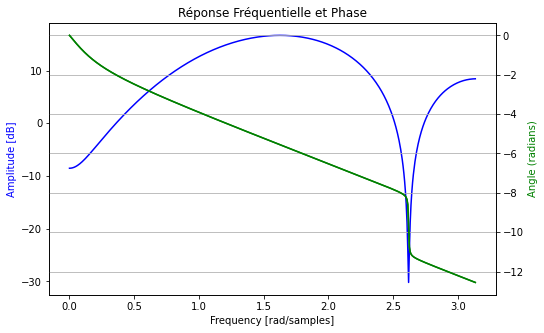

In [6]:
z= np.array([-0.87+0.5j, -0.87-0.5j, 0.5, 1.2, 2.0])
p= np.array([])
k= 1
(b,a)= signal.zpk2tf(z, p, k)
print("nominateur: {}".format(b))
print("denominateur: {}".format(a))
w, h= signal.freqz(b, a)

fig, ax1 = plt.subplots(1,1,figsize=(8,5))

ax1.set_xlabel('Frequency [rad/samples]')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_title('Réponse Fréquentielle et Phase')
ax1.plot(w, dB(h), color='b')

ax2 = ax1.twinx()
angles_rad = np.unwrap(np.angle(h))
ax2.plot(w, angles_rad, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.plot(w, angles_rad, color='g')
ax2.grid()

**Réponse** : En observant le diagram de Bode on aperçoit que ce filtre est un filtre pass-bande avec une phase linéaire.

### 3. 
Toujours pour le même filtre, avec les zéros ajoutés, proposez un schéma de filtre exploitant la symmétrie des coeficients permettant de limter le nombre de multiplications.

Pour afficher un dessin vous pouvez par exemple:
  - Faire le diagramme en utilisant https://draw.io
  - Exporter le dessin au format png, l'enregistrer dans le même dossier que le notebook
  - Insérer une cellule  en tapant le code suivant dans une cellule **markdown** (en remplacant structure_ex2 par le nom de votre fichier): 

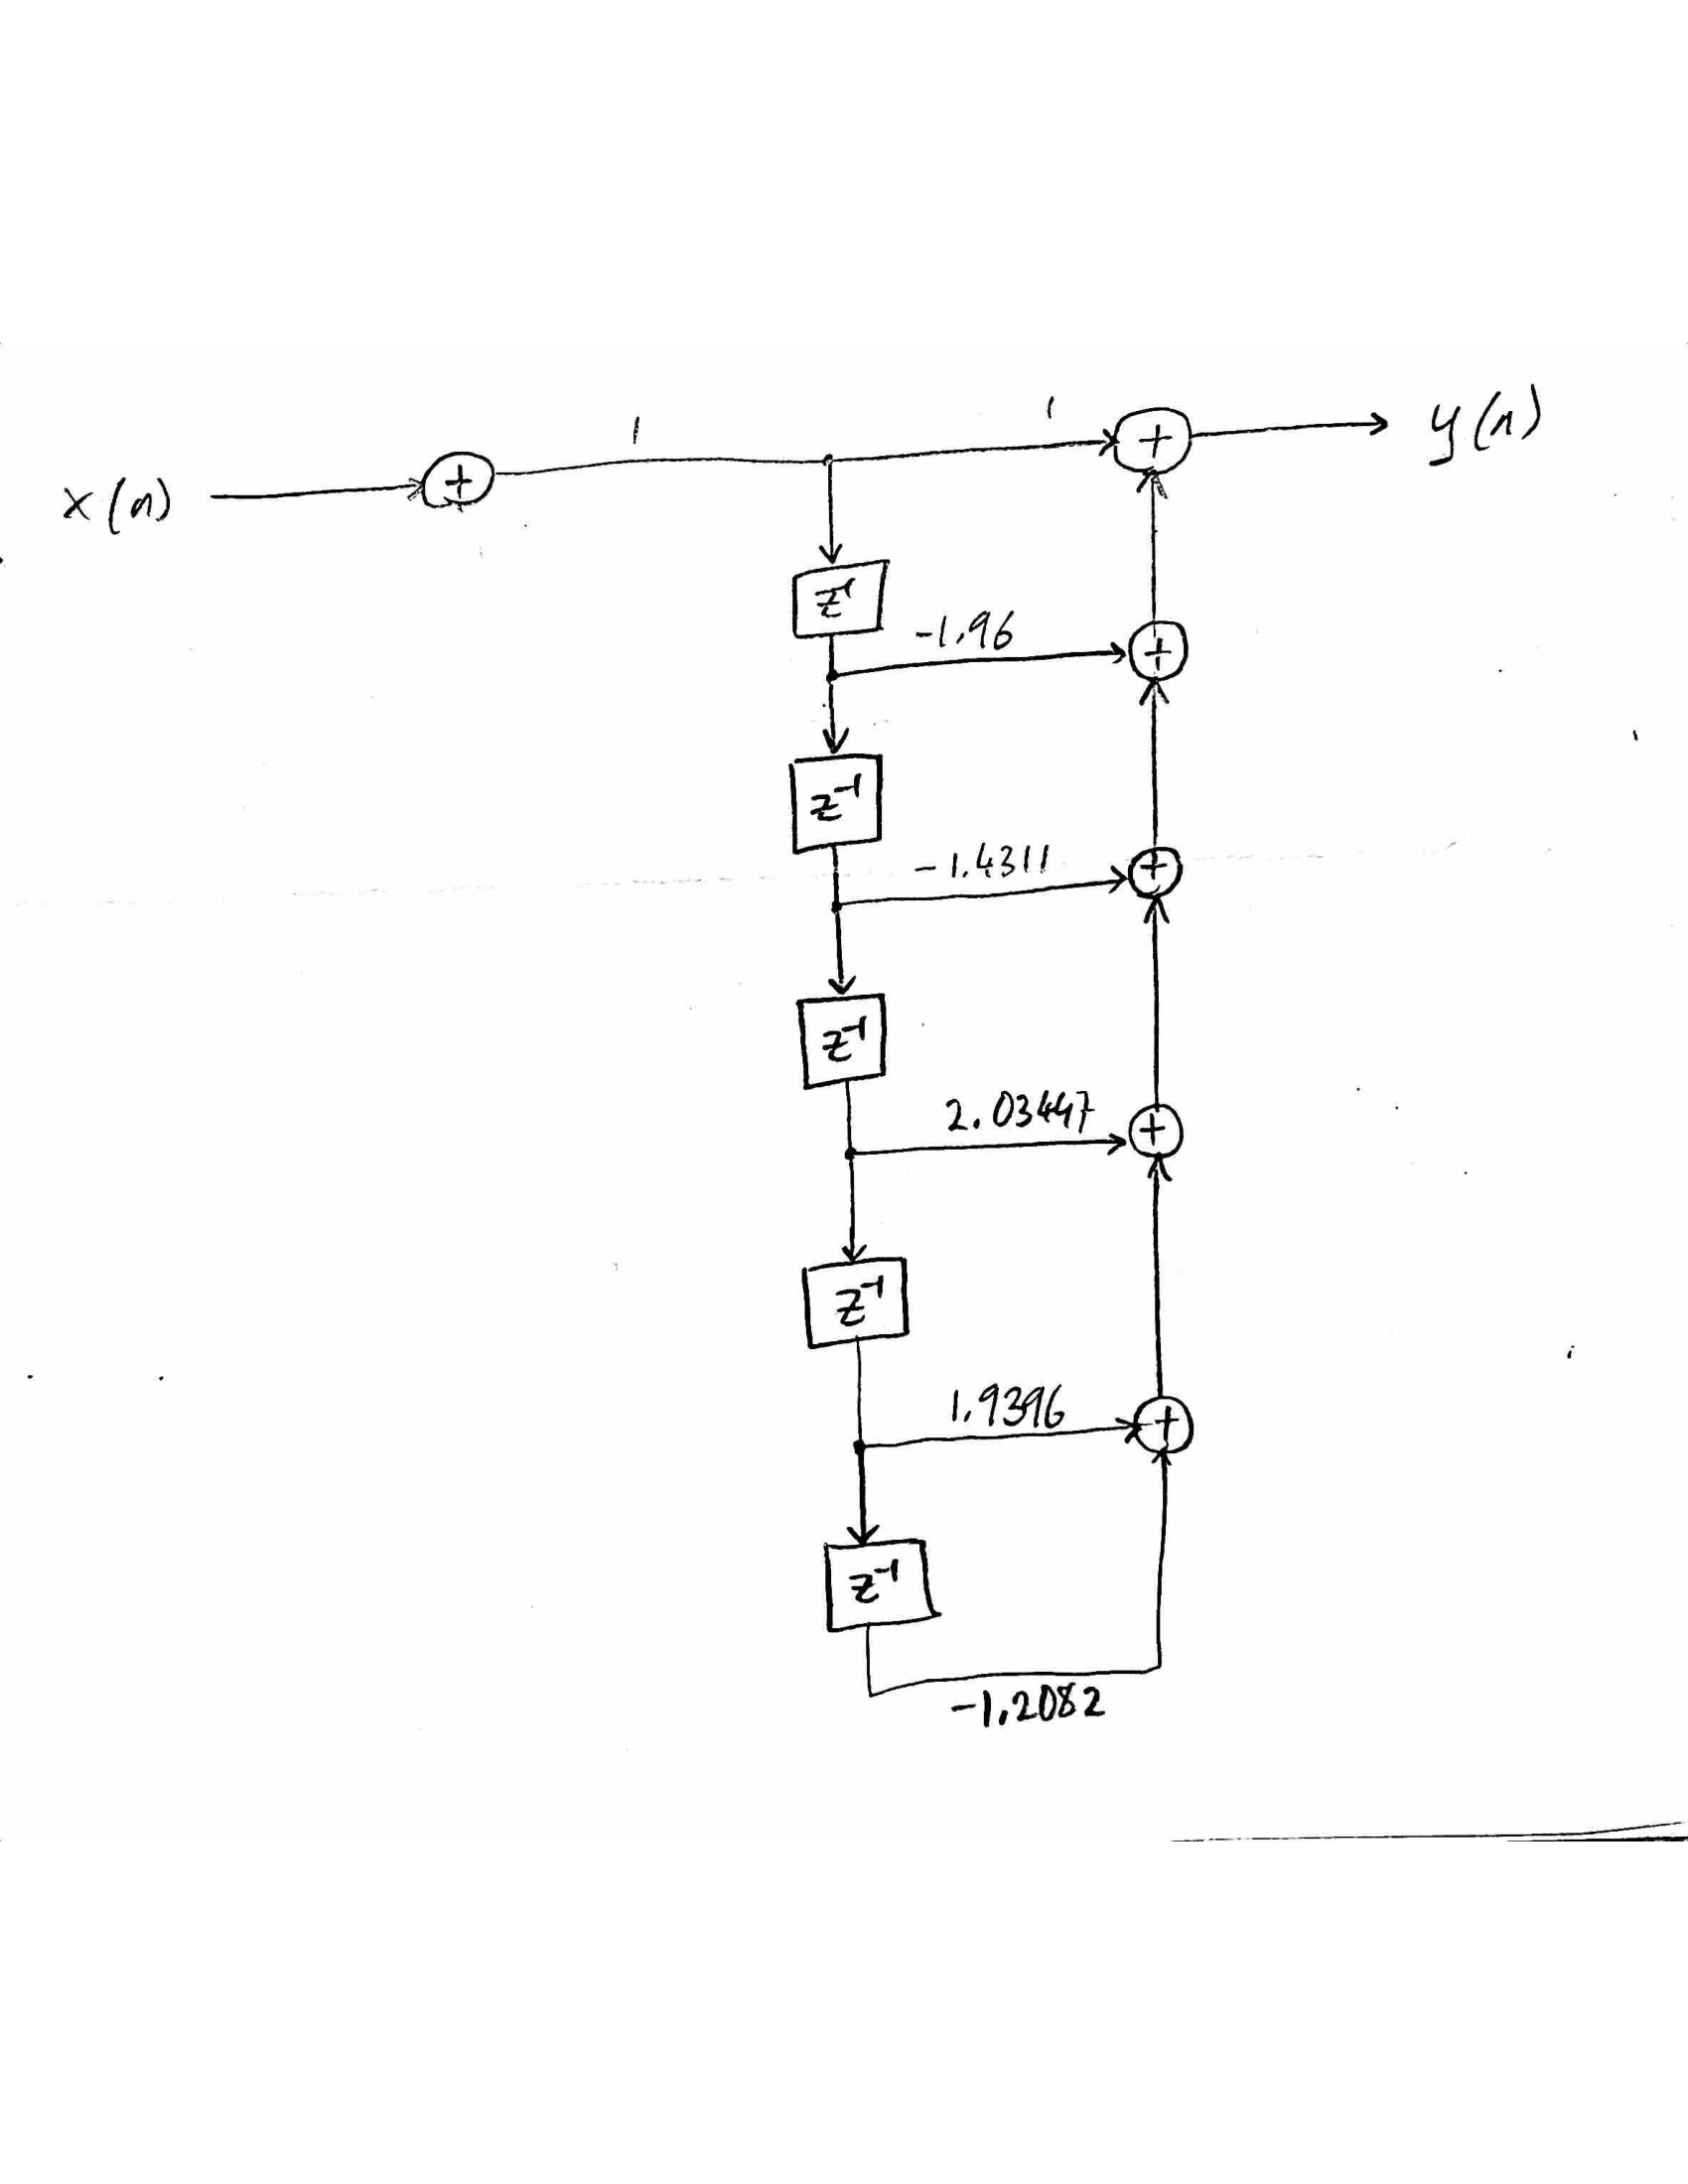

In [7]:
Image(filename = "Filter2.png", width=500, height=500)

## Exercice 3 : Synthèse de filtres par fenêtrage et échantillonage
On considère les signaux de deux fichiers audio: 'harry.wav' et 'queen.wav'

### 1. Fréquence d'échantillonage

* Quelle est la fréquence d'échantillonage des deux fichiers ?

*Utilisez le module wavfile de scipy.* 

In [8]:
#Code 3.1

## Fichier harry
harry_file = 'audioFiles/harry.wav'
harry_fs, harry_data =  wavfile.read(harry_file) 

## Fichier queen
queen_file = 'audioFiles/queen.wav'
queen_fs, queen_data = wavfile.read(queen_file) 

print("Réponse: \nLa fréquence d'échantillonnage de {} est {}kHz, et celle de {} est {}kHz\n".format(
    harry_file, harry_fs/1000.00, queen_file, queen_fs/1000.00))

Réponse: 
La fréquence d'échantillonnage de audioFiles/harry.wav est 44.1kHz, et celle de audioFiles/queen.wav est 48.0kHz



### 2. Amplitude de la transformée de Fourier 

* Tracez l'amplitude (dB) de la transformée de Fourier des deux fichiers.

*Remarque : Normalisez les données et utilisez numpy.fftfreq pour le traçage.*

In [9]:
#Code 3.2

# Normalisez les données
harry_data = harry_data / np.linalg.norm(harry_data)
queen_data = queen_data / np.linalg.norm(queen_data)

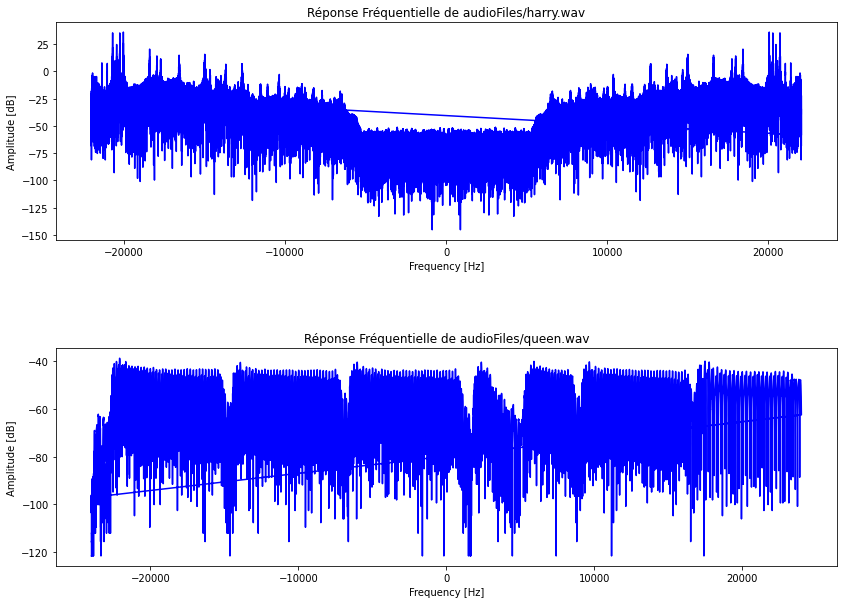

In [44]:
harry_fft = fft.fft(harry_data)
harry_fft_freq= fft.fftshift(harry_fft)

queen_fft = fft.fft(queen_data)
queen_fft_freq = fft.fftshift(queen_data)

# Code pour tracer
harry_w= np.fft.fftfreq(len(harry_data), 1/harry_fs)
queen_w= np.fft.fftfreq(len(queen_data), 1/queen_fs)

fig, axs = plt.subplots(2,1,figsize=(14,10))
fig.subplots_adjust(hspace = 0.5)

axs[0].set_xlabel('Frequency [Hz]')
axs[0].set_ylabel('Amplitude [dB]')
axs[0].set_title("Réponse Fréquentielle de {}".format(harry_file))
axs[0].plot(harry_w, dB(harry_fft_freq.real), color='b')

axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Amplitude [dB]')
axs[1].set_title("Réponse Fréquentielle de {}".format(queen_file))
axs[1].plot(queen_w, dB(queen_fft_freq.real), color='b')

plt.show()

### 3. Design de filtre par fenêtrage

#### 3.a En utilisant le module firwin de Scipy, construisez un filtre passe-bas à 201 coefficients avec une fréquence de coupure de 1 kHz en utilisant les fenêtres suivantes : 
* Hamming 
* fenêtre rectangulaire (boxcar)

Pour chaque fenêtre : 
1. Tracez la réponse impulsionnelle du filtre.
2. Tracez la transformée de Fourier du filtre, et marquez la fréquence de coupure.(*Astuce : utilisez matplotlib.pyplot.axvline*)
3.  Expliquez quelle fenêtre vous parait la meilleure.
 
*Note: Supposez le taux d'échantillonnage pour la fenêtre = taux d'échantillonnage de queen.wav*

In [47]:
# Code 3.a.1
M = 200 #l'ordre du filtre
cutoff = 1000 #Hz
fir_hamming = signal.firwin(M+1, cutoff, window='hamming', pass_zero='lowpass', fs = queen_fs)
fir_rect = signal.firwin(M+1, cutoff, window='boxcar', pass_zero='lowpass', fs= queen_fs)

# Code 3.a.2
hamming_fft =  fft.fft(fir_hamming)
rect_fft = fft.fft(fir_rect)

hamming_fft_freq = np.fft.fftfreq(len(fir_hamming), 1/queen_fs)
rect_fft_freq = np.fft.fftfreq(len(fir_rect), 1/queen_fs)

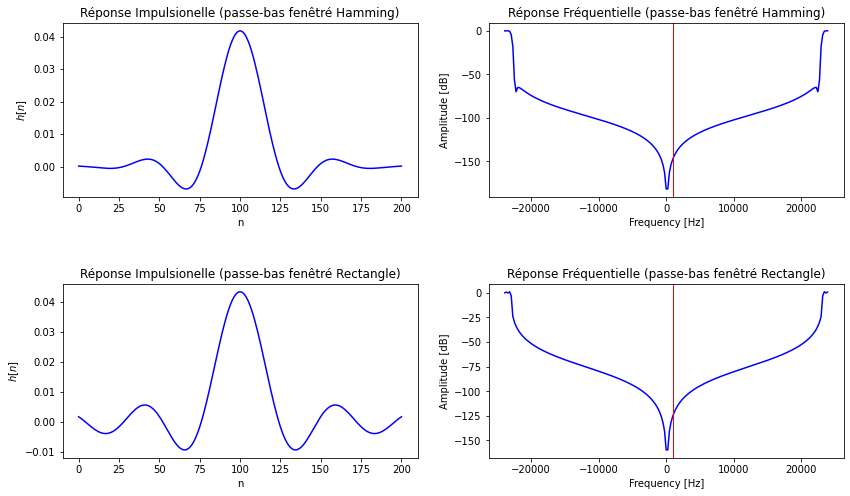

In [48]:
# Code pour tracer
fig, axs = plt.subplots(2,2,figsize=(14,8))
fig.subplots_adjust(hspace = 0.5)

axs[0][0].set_xlabel('n')
axs[0][0].set_ylabel('$h[n]$')
axs[0][0].set_title("Réponse Impulsionelle (passe-bas fenêtré Hamming)")
axs[0][0].plot(fir_hamming, color='b')                    

axs[0][1].set_xlabel('Frequency [Hz]')
axs[0][1].set_ylabel('Amplitude [dB]')
axs[0][1].set_title("Réponse Fréquentielle (passe-bas fenêtré Hamming)")
axs[0][1].plot(hamming_fft_freq, dB(hamming_fft.real), color='b')
axs[0][1].axvline(x=cutoff, linewidth=1, color='r')
#plt.text(cutoff, 0, "$\omega=1$", rotation=90)

                          
axs[1][0].set_xlabel('n')
axs[1][0].set_ylabel('$h[n]$')
axs[1][0].set_title("Réponse Impulsionelle (passe-bas fenêtré Rectangle)")
axs[1][0].plot(fir_rect, color='b')                                
                 
axs[1][1].set_xlabel('Frequency [Hz]')
axs[1][1].set_ylabel('Amplitude [dB]')
axs[1][1].set_title("Réponse Fréquentielle (passe-bas fenêtré Rectangle)")
axs[1][1].plot(rect_fft_freq, dB(rect_fft.real), color='b')
axs[1][1].axvline(x=cutoff, linewidth=1, color='r')

plt.show()

##### Analyse (3.a.3)  : 
Le filtre passe-bas à partir de la fenêtre Hamming parait la meilleure car la bande de transition est plus petite que celle du filtre passe-bas à partir de la fenêtre rectuangular. Deuxièment, son attenuation de dans la bande coupée est plus sevère que celle du filtre passe-bas crée avec une fenêtre rectangulaire. 

#### 3.b Filtres passe-bas
1. En utilisant le filtre passe-bas construit avec la fenêtre de Hamming, filtrez les deux signaux originaux.
2. Enregistrez les signaux filtrés sous forme de fichiers harry_low.wav et queen_low.wav à l'aide de la fonction wavfile.write. Remarque : Normalisez le signal avant d'écrire dans le fichier .wav.
3. Affichez l'amplitude (dB) de la transformée de Fourier des signaux filtrés, et marquez la fréquence de coupure.

In [49]:
#Code 3.b.1 et 3.b.2
y_low_harry = np.convolve(harry_data, fir_hamming)# convoluer harry_data et fir_hamming
y_low_harry = y_low_harry / np.linalg.norm(y_low_harry) # Normalisez le signal
wavfile.write('audioFiles/harry_low.wav', harry_fs, y_low_harry.astype(np.float32)) #  Enregistrez les signaux filtrés

y_low_queen = np.convolve(queen_data, fir_hamming)
y_low_queen = y_low_queen / np.linalg.norm(y_low_queen)
wavfile.write('audioFiles/queen_low.wav', int(queen_fs), y_low_queen.astype(np.float32)) 

In [50]:
# Code 3.b.3
harry_low_fft = fft.fft(y_low_harry)
harry_low_fft_freq = np.fft.fftfreq(len(y_low_harry), 1/harry_fs) # fréquences de fft of y_low_harry

queen_low_fft = fft.fft(y_low_queen)
queen_low_fft_freq = np.fft.fftfreq(len(y_low_queen), 1/queen_fs)

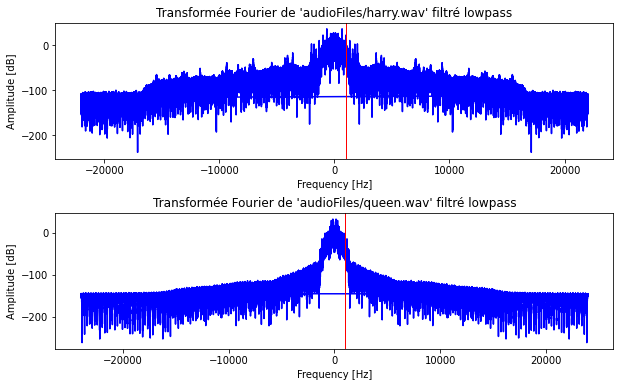

In [54]:
# Code pour tracer
fig, axs = plt.subplots(2,1,figsize=(10,6))
fig.subplots_adjust(hspace = 0.4)

axs[0].set_xlabel('Frequency [Hz]')
axs[0].set_ylabel('Amplitude [dB]')
axs[0].set_title("Transformée Fourier de \'{}\' filtré lowpass".format(harry_file))
axs[0].plot(harry_low_fft_freq, dB(harry_low_fft.real), color='b')
axs[0].axvline(x=cutoff, linewidth=1, color='r')

axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Amplitude [dB]')
axs[1].set_title("Transformée Fourier de \'{}\' filtré lowpass".format(queen_file))
axs[1].plot(queen_low_fft_freq, dB(queen_low_fft.real), color='b')
axs[1].axvline(x=cutoff, linewidth=1, color='r')

plt.show()

#### 3.c Filtres passe-haut
1. Construisez un filtre passe-haut avec 201 coefficients et une fréquence de coupure de 2 kHz. Utilisez la fenêtre de Hamming.
2. Affichez l'amplitude de la transformée de Fourier du filtre.
3. Appliquez ce filtre aux deux signaux originaux et enregistrez les signaux filtrés sous forme de fichiers harry_high.wav et queen_high.wav à l'aide de la fonction wavfile.write. Remarque : Normalisez le signal avant d'écrire dans le fichier .wav.
4. Affichez l'amplitude (dB) de la transformée de Fourier des signaux filtrés, et marquez la fréquence de coupure.


In [88]:
# Code 3.c.1
M = 200 #l'ordre du filtre
cutoff = 2000 #Hz
high_pass = signal.firwin(M+1, 200, window='hamming', pass_zero='highpass', fs = queen_fs)


In [89]:
# Code 3.c.2
high_pass_fft = fft.fftshift(fft.fft(high_pass)) # fft de filtre passe-haut
high_pass_fft_freq = fft.fftshift(np.fft.fftfreq(high_pass.size, 0.5))#1/len(queen_data)) # fréquences de fft 

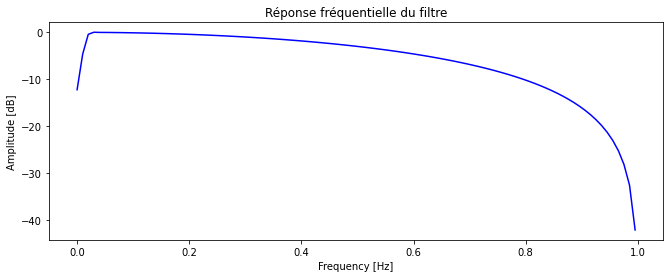

In [90]:
# Code pour tracer
fig, ax = plt.subplots(1,1,figsize=(11,4))

tmp=int(len(high_pass_fft)/2)
ax.plot(high_pass_fft_freq[tmp:], dB(high_pass_fft.real[tmp:]), color='b')
#ax.axvline(x=cutoff, linewidth=1, color='r')  #cutoff frequency
ax.set_title("Réponse fréquentielle du filtre")
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')

plt.show()

In [74]:
# Code 3.c.3
y_high_harry = np.convolve(harry_data, high_pass) # convoluer harry_data et high_pass
y_high_harry = y_high_harry / np.linalg.norm(y_high_harry) # Normalisez le signal
wavfile.write('audioFiles/harry_high.wav', int(harry_fs), y_high_harry.astype(np.float32)) #  Enregistrez les signaux filtrés

y_high_queen = np.convolve(queen_data, high_pass)
y_high_queen = y_high_queen / np.linalg.norm(y_high_queen)
wavfile.write('audioFiles/queen_high.wav', queen_fs, y_high_queen.astype(np.float32)) #  Enregistrez les signaux filtrés
#plt.plot(y_high_harry)

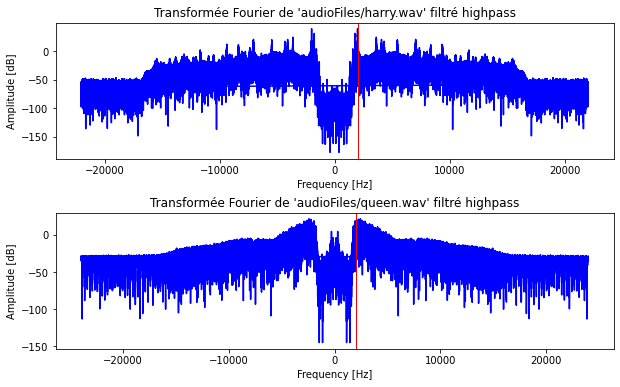

In [75]:
# Code 3.c.4
harry_high_fft = fft.fft(y_high_harry) # fft of y_high_harry
harry_high_fft_freq = np.fft.fftfreq(len(y_high_harry), 1/harry_fs) # frequencies of fft of y_high_harry

queen_high_fft = fft.fft(y_high_queen) 
queen_high_fft_freq = np.fft.fftfreq(len(y_high_queen), 1/queen_fs)

## Code for plotting signals
fig, axs = plt.subplots(2,1,figsize=(10,6))
fig.subplots_adjust(hspace = 0.4)

axs[0].set_xlabel('Frequency [Hz]')
axs[0].set_ylabel('Amplitude [dB]')
axs[0].set_title("Transformée Fourier de \'{}\' filtré highpass".format(harry_file))
axs[0].plot(harry_high_fft_freq, dB(harry_high_fft.real), color='b')
axs[0].axvline(x=cutoff, linewidth=1, color='r')

axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Amplitude [dB]')
axs[1].set_title("Transformée Fourier de \'{}\' filtré highpass".format(queen_file))
axs[1].plot(queen_high_fft_freq, dB(queen_high_fft.real), color='b')
axs[1].axvline(x=cutoff, linewidth=1, color='r')

plt.show()

### 4. Différences audibles
Écoutez les signaux filtrés par le filtre passe-bas (harry_low.wav et queen_low.wav) et le passe-haut (harry_high.wav et queen_high.wav). Pour chaque fichier (queen et harry), quel signal filtré ressemble le plus à l'original ? Pourquoi ?

#### Analyse : 